# Business Cycle Dating with Machine Learning

**Thomas Sargent, Natasha Watkins and Quentin Batista**

## Introduction

The objective of this notebook is to classify time periods between the normal state of the economy and recession periods in the fashion of the National Bureau of Economic Research (NBER). The NBER provides [some guidance](http://www.nber.org/cycles/recessions.html) on how it dates recession periods. However, it does not tell us exactly how much weight is placed on each economic indicator in that process. In this notebook, we build a system that attempts to mimic the NBER. For this purpose, we use multiple classification techniques implemented in the `sklearn` library in Python. Note that this is a different goal than that of infering how much weights the NBER puts on each indicator. Our models should not be interpreted in this way because (i) the NBER claims not to be using a fixed rule when dating business cycles and (ii) even if there existed such a rule, it is very likely to have changed over time as members of the NBER committee and the indicators they use changed, and (iii) machine learning algorithms can typically produce multiple functions with similar prediction quality for a given dataset, making inference difficult as shown in Mullainathan and Spiess (2017).

The NBER mentions using various economic indicators, including:

- Real GDP measured on the product and income side
- Economy-wide employment
- Real Income
- Real Sales
- The Federal Reserve's index of industrial production (IP)

The NBER classifies months. However, the Bureau of Economic Analysis (BEA) only releases GDP statistics on a quarterly basis. As such, the NBER also uses some monthly estimates as supplements. 

In our application, we do not use all the indicators that the NBER mentions using because we want the data to be relatively long, and many indicators are only available on different time frames, some of which are relatively short. There are techniques that allow to deal with time series with variable lengths, but we leave this analysis for future work.

## Downloading the Data Using `fredapi`

`fredapi` is a Python package that enables retreiving economic series from the FRED database. Below, we use it to download the time series for the economic indicators we will be using as features to create our models.

In [1]:
from fredapi import Fred
import pandas as pd
import numpy as np

fred = Fred(api_key='16fc433e0cb217bb8cb94bf76b981f2f') # Need to register for API key

# Get series from FRED database

indicator = fred.get_series('USREC')
gdp = fred.get_series('GDPC1')
gdp_growth = fred.get_series('A191RL1Q225SBEA')
unemploy = fred.get_series('UNRATE')
tbill = fred.get_series('TB3MS')
cpi = fred.get_series('CPIAUCNS')
indust_growth = fred.get_series('INDPRO').pct_change()
manfac_growth = fred.get_series('MANEMP').pct_change()
minwage_growth = fred.get_series('FEDMINNFRWG').pct_change()
payroll = fred.get_series('PAYEMS')

In [2]:
infl = cpi.pct_change()

# # Construct a dataframe

data = pd.concat([indicator,
                           unemploy,
                           tbill,
                           infl,
                           manfac_growth,
                           indust_growth,
                           payroll,
                           gdp_growth.resample('M').first().fillna(method='ffill')],
                           axis=1).resample('M').first().dropna(how='any')

data.columns = 'Recession', 'Unemployment', 'T-bill', 'Inflation', 'Manufacturing growth', 'Industrial growth', 'Payroll', 'GDP Growth'
# data.to_csv('NBERrecessionData.csv')
# gdp_growth.to_csv('GDPgrowth.csv')

In [3]:
# Import data from CSV files
# data = pd.read_csv('NBERrecessionData.csv', index_col=0)
data.index = pd.to_datetime(data.index)

#gdp_growth = pd.Series.from_csv('GDPgrowth.csv', index_col=0)
gdp_growth.index = gdp_growth.index.to_period('M').to_timestamp('M')
gdp_growth.name = 'GDP growth'

data.head()

,Recession,Unemployment,T-bill,Inflation,Manufacturing growth,Industrial growth,Payroll,GDP Growth
1948-01-31,0.0,3.4,0.97,0.012821,0.000693,0.005664,44682.0,6.0
1948-02-29,0.0,3.8,1.00,-0.008439,-0.006857,0.001875,44537.0,6.0
1948-03-31,0.0,4.0,1.00,-0.004255,0.001743,-0.011236,44681.0,6.0
1948-04-30,0.0,3.9,1.00,0.017094,-0.012601,0.001893,44370.0,6.7
1948-05-31,0.0,3.5,1.00,0.004202,0.003666,0.017011,44795.0,6.7


## Recessions According to the NBER

In the following plot, shaded regions indicate a recession as classified by the NBER.

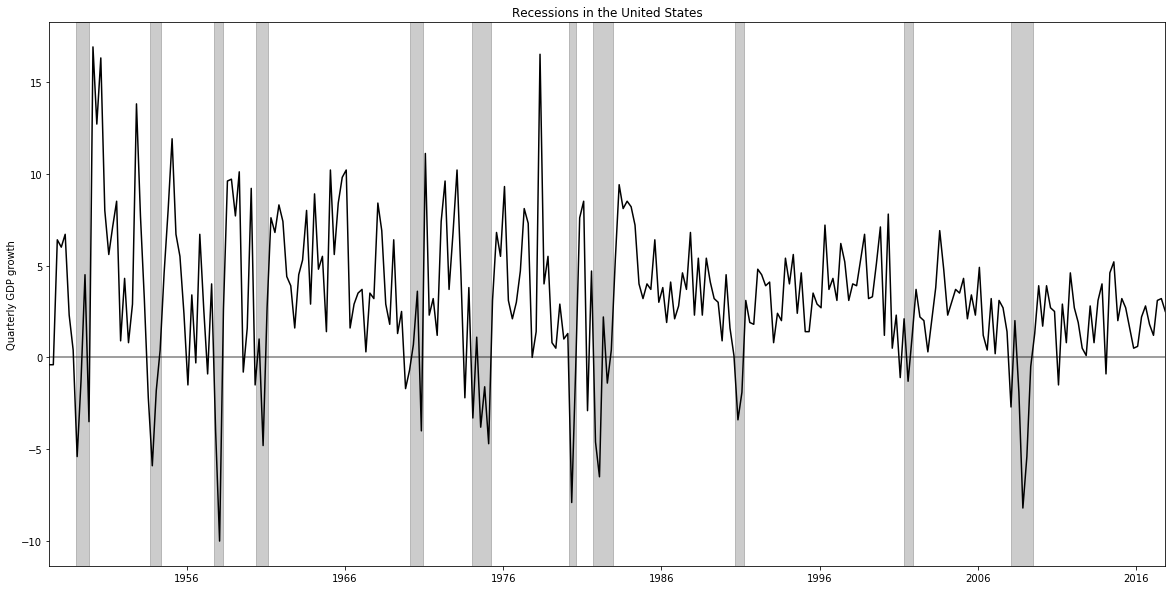

In [4]:
# Plot recessions against GDP growth
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

%matplotlib inline 

plt.figure(figsize=(20,10))
trans = mtransforms.blended_transform_factory(plt.gca().transData, 
                                              plt.gca().transAxes)

plt.axhline(color='black', alpha=0.5)
plt.plot(gdp_growth, color='black')
plt.fill_between(data.index, 
                       data['Recession'], 
                       transform=trans, 
                       alpha=0.2, 
                       color='black',
                       where=data['Recession'] == 1)
plt.xlim(min(gdp_growth.index), max(gdp_growth.index))
plt.title('Recessions in the United States')
plt.ylabel('Quarterly GDP growth')
plt.show()

## Technical Recessions

An alternative definition of a recession is two consecutive quarter of negative economic growth. These periods are shown in the plot below. This reveals a clear difference between what the NBER considers a recession and the technical definition.

In [5]:
tech_recess = pd.Series(np.zeros(len(gdp_growth)), index=gdp_growth.index)

for i in range(len(gdp_growth) - 1):
    if (gdp_growth[i+1] < 0) & (gdp_growth[i] < 0):
        tech_recess[i] = 1
        tech_recess[i+1] = 1
    else:
        tech_recess[i+1] = 0

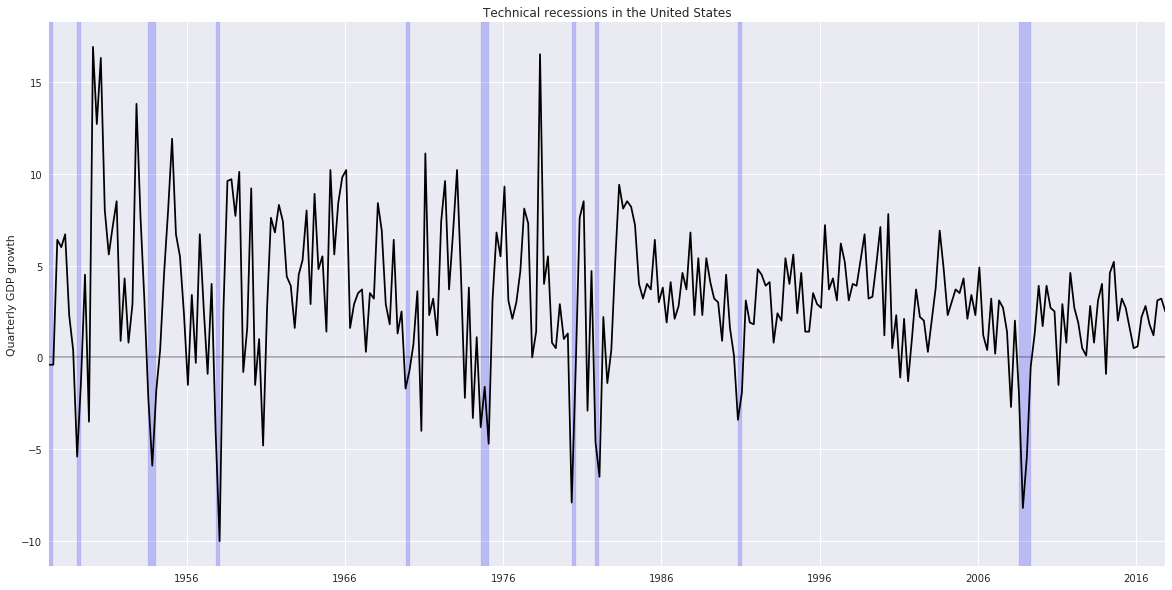

In [6]:
# Plot technical recessions against GDP growth

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
plt.style.use('seaborn')

plt.figure(figsize=(20,10))
trans = mtransforms.blended_transform_factory(plt.gca().transData, 
                                              plt.gca().transAxes)

plt.axhline(color='black', alpha=0.3)
plt.plot(gdp_growth, color='black')
plt.fill_between(tech_recess.index, 
                 tech_recess, 
                 transform=trans, 
                 alpha=0.2, 
                 color='blue',
                 where=tech_recess == 1)
plt.xlim(min(gdp_growth.index), max(gdp_growth.index))
plt.title('Technical recessions in the United States')
plt.ylabel('Quarterly GDP growth')
plt.show()

## Exploring the Data

This plot shows:

* histograms of variables in X along the diagonal
* scatterplots of each pair in X on the off-diagonal, with observations coloured by indicator (y=0 or y=1)

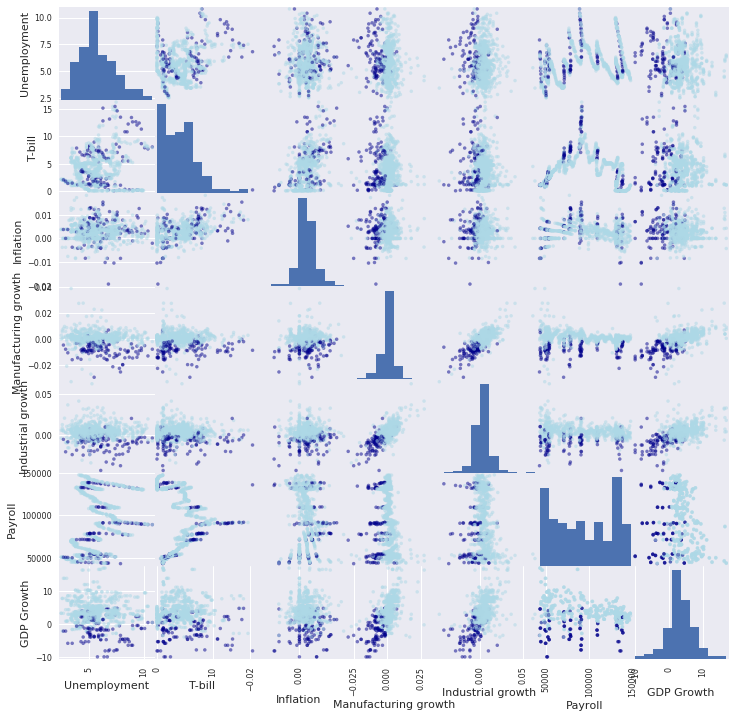

In [7]:
colMap = {0:"LightBlue", 1:"DarkBlue"}
cols = list(map(lambda x:colMap.get(x), data['Recession']))
pd.plotting.scatter_matrix(data.iloc[:,1:], figsize=[12,12], c=cols, alpha=0.5)
plt.show()

## Setting Up Training and Testing Sets

In Machine Learning, the data used to build the final model usually comes from multiple datasets. Here, we do a first split between a training (70%) and test (30%) set.

In [8]:
# Define complete sets

X = data.iloc[:,1:]
y = data.iloc[:,0]

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.3, random_state = 9)

print('Sample size: ' + str(y.size))
print('Training set size: ' + str(ytrain.size))
print('Testing set size: ' + str(ytest.size))

Sample size: 838
Training set size: 586
Testing set size: 252


## The Model Building Process

Fitting a model is easy: many techniques can be implemented all in two lines of code thanks to open-source libraries. However, evaluating and selecting the model requires more thought.

### [How to Evaluate Models](https://www.cs.cornell.edu/courses/cs578/2003fa/performance_measures.pdf)

Here, we introduce some of the metrics used to evaluate the performance of models. 

**Accuracy** measure is calculated as $accuracy = \frac{correct\ predictions }{all\ predictions}$

<img src="http://i.imgur.com/Yq7gDvh.png" width="50%" >

**Precision** is calculated as $precision = \frac{true\ positives }{all\ predicted\ positives}$
* This tells us how many of the predicted positives are correct

**Recall** is calculated as $recall = \frac{true\ positives }{all\ true\ positives}$
* This tells us how many of the true positives does the model return

<img src="http://i.imgur.com/p92QcCF.png" width="50%">

**F-measure** is calculated as $F=2\frac{recall\cdot precision}{recall+precision}$
* This is the harmonic mean of precision and recall
* It is sometimes used as an alternative to accuracy when [classes are imbalanced](https://eva.fing.edu.uy/pluginfile.php/69453/mod_resource/content/1/7633-10048-1-PB.pdf); we will be using it for our application for that reason


### How to Select Models

We use a technique called [$k$-fold cross-validation](http://cs229.stanford.edu/notes/cs229-notes5.pdf). Let $S$ denote our training set. 

1. Randomly split $S$ into $k$ disjoint subsets of $m/k$ training examples each. Let's call these subsets $S_{1},\ldots,S_{k}$.
2. For each model $M_{i}$, we evaluate it as follows:  
    For $j=1,\ldots,k$  
    Train the model $M_{i}$ on $S_{1}\cup\ldots\cup S_{j-1}\cup S_{j+1}\cup\ldots\cup S_{k}$ to get some hypothesis $h_{ij}$.  
    Test the hypothesis $h_{ij}$ on $S_{j}$ to get $\hat{\varepsilon}_{S_{j}}\left(h_{ij}\right)$.  
    The estimated generalization error of model $M_{i}$ is then calculated as the average of $\hat{\varepsilon}_{S_{j}}\left(h_{ij}\right)$'s over $j$.
3. Pick the model $M_{i}$ with the lowest generalization error, and retrain the model on the entire training set $S$. The resulting hypothesis is then output as our final answer.    

It is important to realize that the testing set is not used at all in this process. One might be tempted to use the performance of the model on the test set to select the final model because it gives us an estimate of generalization performance. However, this results in a problem known as [data leakage](https://www.kaggle.com/wiki/Leakage), that is, if we further tuned our model to based on test set performance, then the test set performance would not longer be a valid estimate of generalization performance.

In contrast with traditional econometrics, model selection is here outsourced to a machine learning algorithm that is data-driven. This has been identified by Athey (2018) as a key theme of machine learning which could transform economics in the future as it "enables researchers to be systematic and fully describe the process by which their model as selected".

## Quick Prototyping with a Simple Decision Tree

Andrew Ng's [recommendation](http://cs229.stanford.edu/materials/ML-advice.pdf) for getting started on a learning problem is to implement something quick-and-dirty and see what is wrong with it. Here, we apply this recommendation by building a simple [decision tree classifier](http://scikit-learn.org/stable/modules/tree.html#tree) and analyzing its output. 

In [9]:
# Add tree to visualize decision rule
from sklearn import tree

model_tree = tree.DecisionTreeClassifier()
model_tree.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [ ]:
from IPython.display import Image
import pydotplus

dot_data = tree.export_graphviz(model_tree, out_file=None,
                         filled=True, rounded=True,  
                         special_characters=True,
                         feature_names = X.columns)  
Image(pydotplus.graph_from_dot_data(dot_data).create_png())

In [17]:
from sklearn import metrics

# Predict recessions using the test data
ypred_tree = model_tree.predict(Xtest)
print(metrics.classification_report(ytest, ypred_tree))

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96       215
        1.0       0.78      0.76      0.77        37

avg / total       0.93      0.93      0.93       252



An easier way to absorb the information contained in these metrics is using a confusion matrix, as shown below.

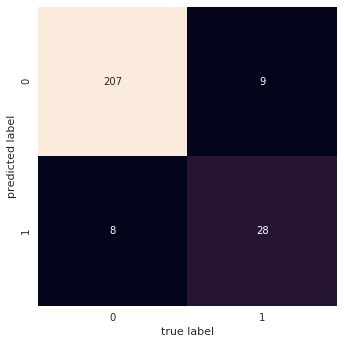

In [20]:
import seaborn as sns

def confusion_matrix_visualization(ytest, y_pred):
    mat = metrics.confusion_matrix(ytest, y_pred)
    metrics.confusion_matrix(ytest, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

confusion_matrix_visualization(ytest, ypred_tree)

Finally, we can evaluate the models by looking at what it is predicting correctly and incorrectly, which we do here visually.

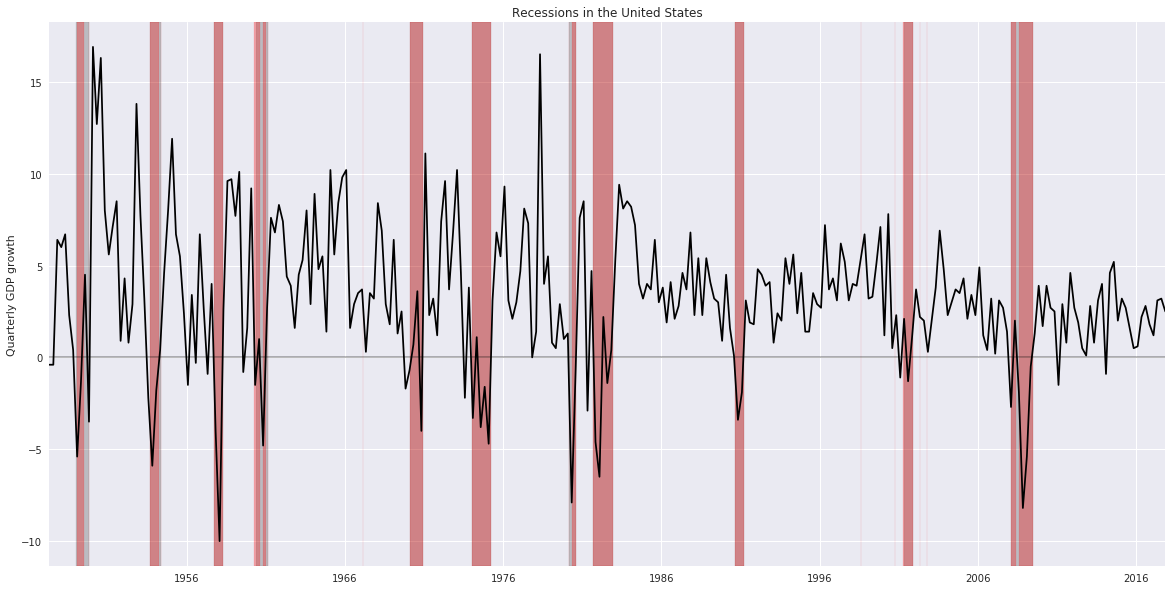

In [21]:
def prediction_visualization(y_pred, data, X):
    recession_pred = pd.Series(y_pred, index=X.index)

    plt.figure(figsize=(20,10))
    trans = mtransforms.blended_transform_factory(plt.gca().transData, 
                                                  plt.gca().transAxes)

    plt.axhline(color='black', alpha=0.3)
    plt.plot(gdp_growth, color='black')

    # Plot original recession data

    plt.fill_between(data.index, 
                          data['Recession'], 
                          transform=trans, 
                          alpha=0.2, 
                          color='black',
                          where=data['Recession'] == 1)

    # Plot predicted recession data

    plt.fill_between(recession_pred.index, 
                           recession_pred, 
                           transform=trans, 
                           alpha=0.3, 
                           color='red',
                           where=recession_pred == 1)

    plt.title('Recessions in the United States')
    plt.ylabel('Quarterly GDP growth')
    plt.xlim(min(gdp_growth.index), max(gdp_growth.index))
    plt.show()
    
prediction_visualization(model_tree.predict(X), data, X)

This plot reveals one area for improvement: the model is missing the dynamic aspect this learning problem. Suppose that in the middle of a 36 months recession, one month shows significantly better economic conditions as a result of some temporary positive shock followed by a return to the recession level of economic activity. Then, the model will likely classify this as being a normal period, while the NBER would likely consider this month as still part of the recession. We do some basic feature engineering to address this problem.

## Updating the Features

The approach we take here is to add 6 months worth of leading and lagged values of the economic indicators. This implies that for a given label $y_{t}$, we include the original features $x_{t}$ but also $x_{j}$ for $j=t-6,\,...,\,t-1,\,t+1,\,...,\,t+6$.

One might argue that this is problematic because if we try to classify today's month, we will not have all the data to do so. However, this is actually the approach taken by the NBER; recession periods are classified as such several months after they have occured. 

Building a classifier for making contemporaneous predictions is nonetheless an interesting problem, and the models we build can be applied to it. This can be achieved by running the analysis below with `leads` set equal to 1.

Finally, intuitively, the hardest points to predict are the beginning and start of a recession. As such, we update the stratification of the data to make sure that these are equally represented between the training and test set. 

In [22]:
from sklearn.preprocessing import MinMaxScaler
 
lags = 6
leads  = 7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Load dataset
values = data.loc[:, data.columns != 'Inflation (t-1)'].values

# Ensure all data is float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Frame as supervised learning
reframed = series_to_supervised(scaled, lags, leads)
reframed.head()

# Update
X_updated = reframed.loc[:, ['var1' not in col_name for col_name in reframed.columns]]
y_updated = reframed.loc[:, 'var1(t)']

# Distinguish between transitions and middle of recession
y_transition = (y_updated + y_updated.shift(1)*3).fillna(0)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_updated, y_updated, stratify=y_transition, test_size=0.3, random_state=9)

X_pred_vis = X[lags:(len(X)-leads+1)]

## Data Visualization

Before building new models, we visualize the data to try to uncover some underlying structure. We use a dimensionality reduction technique called t-SNE to visualize the updated features in a 2 dimensional Euclidean space. It is important to be careful when intrepreting t-SNE plots as [they can sometimes be misleading](https://distill.pub/2016/misread-tsne/). In particular:
- Hyperparameters really matter; `perplexity` is, in a sense, a guess about the number of close neighbors each point has
- Cluster sizes in a t-SNE plot mean nothing
- Distances between clusters might not mean anything

In [23]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, LabelSet, Legend, HoverTool
from bokeh.palettes import all_palettes
from sklearn.manifold import TSNE

output_notebook()

tsne = TSNE(n_components=2, random_state=0, perplexity=36.0)

X_vis = tsne.fit_transform(X_updated)

visdata = pd.DataFrame([X_vis[:,0], X_vis[:,1], y_transition]).T
visdata.columns = 'X1', 'X2', 'Y'

visdata['date'] = data.index[X_updated.index].astype(str)

legend_map = {0: 'Normal Period',
                       1: 'Start of a Recession Period',
                       4: 'Recession Period',
                       3: 'End of a Recession Period'}

category_items = visdata['Y'].unique()
palette = all_palettes['Set1'][len(category_items)]
colormap = dict(zip(category_items, palette))
visdata['Color'] = visdata['Y'].map(colormap)
visdata['Legend'] = visdata['Y'].map(legend_map)

TOOLS = "crosshair,pan,wheel_zoom,reset,tap,save,box_select"

source = ColumnDataSource(dict(x=visdata['X1'],  y=visdata['X2'], color=visdata['Color'], cls=visdata['Legend'], date=visdata['date']))

hover = HoverTool(tooltips=[("date", "@date")])

p = figure(tools=[TOOLS, hover], plot_width=800, plot_height=700)

labels = LabelSet(x='x', y='y', text='label', source=source, text_font_size='8pt')

p.scatter(x='x', y='y', color='color', legend='cls', source=source)

p.title.text = "t-SNE Visualization"
p.title.text_font_size = "25px"

show(p)

Loading BokehJS ...

In [24]:
(y_updated + y_updated.shift(1)*3).value_counts()

0.0    692
4.0    111
3.0     11
1.0     11
Name: var1(t), dtype: int64

This plot reveals another difficulty of this problem: some points are much harder to predict that others because (i) they are separation points between the two classes and (ii) the number of observations for these points is lower than for the regular classes.

Another interesting aspect is that t-SNE seems to be undercovering some structural trends in the U.S. economy. There seems to be five different types of periods, marked by jumps in the location of time wise consecutive points: 
- 1950-1970
- 1970-1975
- 1975-1977
- 1978-2008
- 2008-Present  

The first group of points is scattered, possibly suggesting that this was a period of fast change for the U.S. economy, which experienced a post-war boom. This period ended around 1971, when the U.S. economy  The break in 1975 could be related to the structural impact of the 1973 oil shock on the U.S. economy, which entered a period of stagflation in the 70s. The clusters of points in the years leading to the internet crash and the Lehman crisis could be interpreted as an economic boom building up into a bubble.


## Decision Tree with Boosting: AdaBoost

We address this issue by using a technique called AdaBoost. The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data which put more weight on training examples that were incorrectly predicted. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. From now on, we also use `RandomizedSearchCV` for model selection, which performs a random search over an hyperparamter grid for the model, compares them using $k$-fold cross-validation and then fits the model with the best performance on the training set. The `n_iter` parameter determines the number of random searches conducted. `cv` determines the number of fold used for cross validation -- here, we set it equal to 10.

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators': np.arange(10, 1000, 10),
                      'learning_rate': np.arange(0.5, 3, 0.5),}

grid_ada = RandomizedSearchCV(AdaBoostClassifier(), param_grid, scoring='f1', cv=10, n_iter=50, n_jobs=-1, return_train_score=True)

grid_ada.fit(Xtrain, ytrain)
ypred_grid_ada = grid_ada.predict(Xtest)

print(metrics.classification_report(ytest, ypred_grid_ada))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       211
        1.0       0.94      0.81      0.87        37

avg / total       0.96      0.96      0.96       248



In [26]:
grid_ada.cv_results_

{'mean_fit_time': array([ 4.07630081,  5.7801918 ,  0.24558868,  3.92591307,  1.76979504,
         3.49931817,  5.87415237,  2.61556556,  0.08289509,  2.26950018,
         5.16555426,  5.38953249,  4.39833493,  5.5382726 ,  2.16095822,
         0.49360387,  1.79574366,  2.08211246,  0.16489937,  3.9063369 ,
         0.7381403 ,  1.79395924,  0.41199358,  0.40876825,  3.37317233,
         5.47657812,  6.8617712 ,  2.37515197,  3.09682331,  6.83817062,
         0.84373031,  5.5529305 ,  4.33495703,  0.98134692,  0.89719937,
         7.22538316,  3.66229417,  1.67957604,  6.76947443,  2.39399455,
         4.70066888,  6.54261739,  0.65000112,  6.71027005,  1.48915746,
         6.93788054,  5.47590878,  6.87001035,  1.56996849,  3.12058725]),
 'mean_score_time': array([ 0.07424855,  0.08597054,  0.00499806,  0.07847664,  0.09165294,
         0.05228834,  0.0864959 ,  0.04234283,  0.00259383,  0.11945052,
         0.10336099,  0.08029819,  0.06502917,  0.08244736,  0.04298737,
         0.02

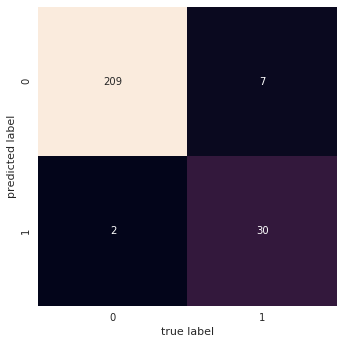

In [27]:
ypred_grid = grid_ada.predict(Xtest)

confusion_matrix_visualization(ytest, ypred_grid)

In [28]:
grid_ada.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=540, random_state=None)

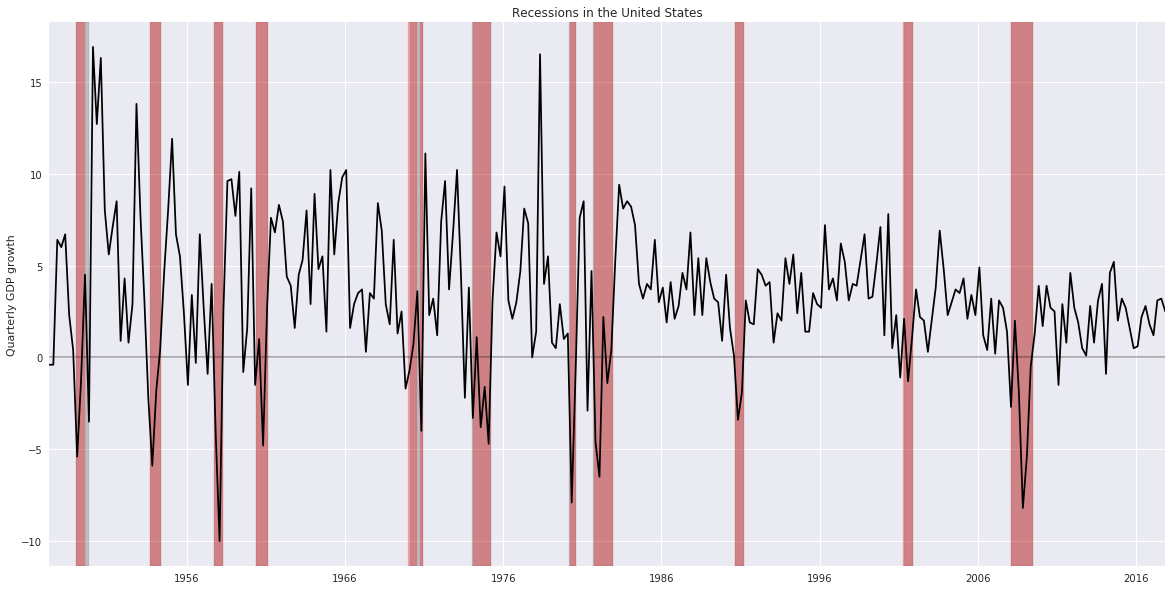

In [29]:
prediction_visualization(grid_ada.predict(X_updated), data, X_pred_vis)

### BaggingClassifier

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Bagging provides a way to reduce overfitting and [work best with strong, complex methods](http://scikit-learn.org/stable/modules/ensemble.html#bagging). As such, we use `grid_ada.best_estimator_` (i.e. the best estimator from the previous search) as its `base_estimator`. 

In [30]:
from sklearn.ensemble import BaggingClassifier

param_grid = {'n_estimators': np.arange(10, 750, 1)}

model_bagging = BaggingClassifier(base_estimator=grid_ada.best_estimator_)

grid_bagging = RandomizedSearchCV(model_bagging, param_grid, scoring='f1', cv=10, n_iter=20, n_jobs=-1, return_train_score=True)
grid_bagging.fit(Xtrain, ytrain)
ypred_bagging = grid_bagging.predict(Xtest)

In [31]:
grid_bagging.cv_results_

{'mean_fit_time': array([  169.15668082,  1291.52298293,   493.73632331,  1637.77529829,
          541.68521283,  1540.01629877,  1399.08566985,  2217.20275428,
          842.29055502,  1611.99625962,   876.30642385,   444.24180834,
          300.7539381 ,  1263.49659641,  1932.2209487 ,  2110.43730733,
         1625.7176688 ,  1784.07176132,  1474.6312922 ,  1674.03738868]),
 'mean_score_time': array([  3.42649586,  26.45049663,  10.35410657,  34.15682018,
         11.27722631,  32.17158792,  29.22642636,  46.10559299,
         17.42426164,  33.20765231,  18.11561697,   9.26222305,
          6.28126404,  26.16889219,  40.43127728,  43.79216924,
         33.92704828,  37.19301617,  30.69652891,  30.2839107 ]),
 'mean_test_score': array([ 0.92173534,  0.92294349,  0.92951789,  0.92294349,  0.93421244,
         0.92294349,  0.92294349,  0.92951789,  0.9163691 ,  0.9163691 ,
         0.92294349,  0.92763804,  0.9163691 ,  0.92294349,  0.92294349,
         0.92294349,  0.92294349,  0.91778

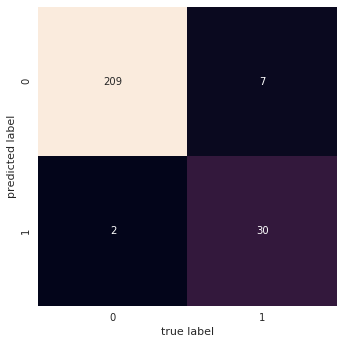

In [32]:
confusion_matrix_visualization(ytest, ypred_bagging)

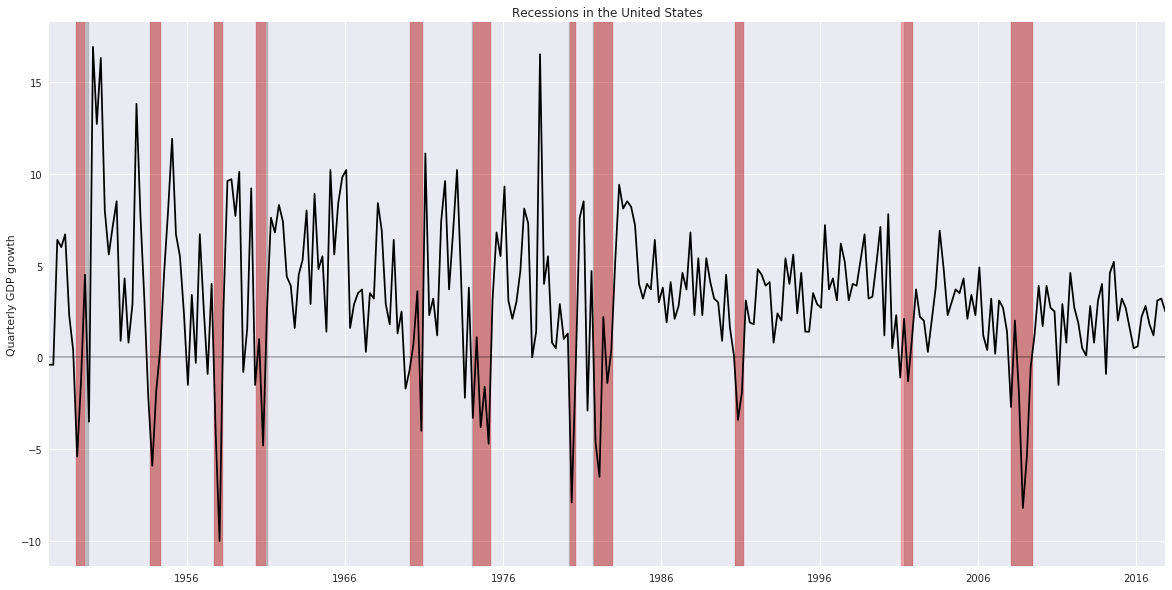

In [33]:
prediction_visualization(grid_bagging.predict(X_updated), data, X_pred_vis)

### k-Nearest Neighbours

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the $k$ nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

In [34]:
import warnings # Filter out warnings because scoring raises a warning
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1, 50, 1),
                      'leaf_size': np.arange(1, 100, 1),
                      'p': np.arange(1, 3, 0.5)}

model_knn = KNeighborsClassifier()

grid_knn = RandomizedSearchCV(model_knn, param_grid, scoring='f1', cv=10, n_iter=50, n_jobs=-1, return_train_score=True, error_score=0.)

grid_knn.fit(Xtrain, ytrain)
ypred_knn = grid_knn.predict(Xtest)

print(metrics.classification_report(ytest, ypred_knn))

             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98       211
        1.0       0.94      0.78      0.85        37

avg / total       0.96      0.96      0.96       248



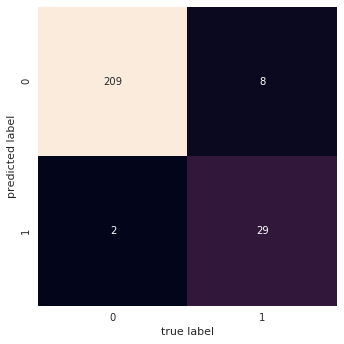

In [35]:
confusion_matrix_visualization(ytest, ypred_knn)

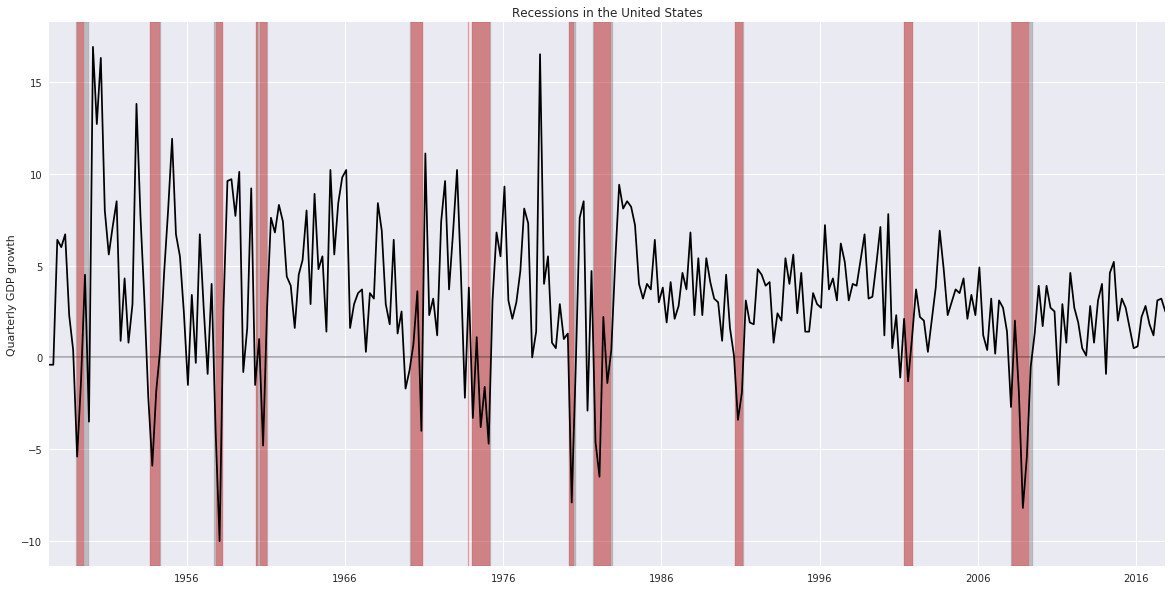

In [36]:
prediction_visualization(grid_knn.predict(X_updated), data, X_pred_vis)

### Support Vector Machine

Support Vector Machine (SVM) is a classier method that performs classification tasks by constructing hyperplanes in a multidimensional space that separates cases of different class labels. 

In [37]:
from sklearn.svm import SVC

param_grid = {'C': np.arange(0.5, 5, 0.5),
                      'kernel': ['rbf', 'poly', 'sigmoid']}

model_svc = SVC()
grid_svc = RandomizedSearchCV(model_svc, param_grid, scoring='f1', cv=10, n_iter=10, return_train_score=True)
grid_svc.fit(Xtrain, ytrain)
ypred_svc = grid_svc.predict(Xtest)

print(metrics.classification_report(ytest, ypred_svc))

             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97       211
        1.0       0.96      0.65      0.77        37

avg / total       0.94      0.94      0.94       248



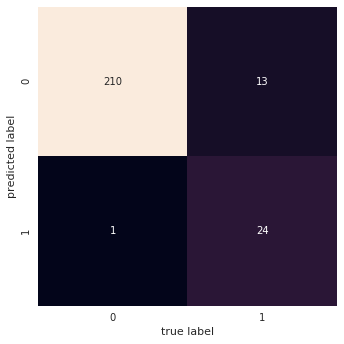

In [38]:
confusion_matrix_visualization(ytest, ypred_svc)

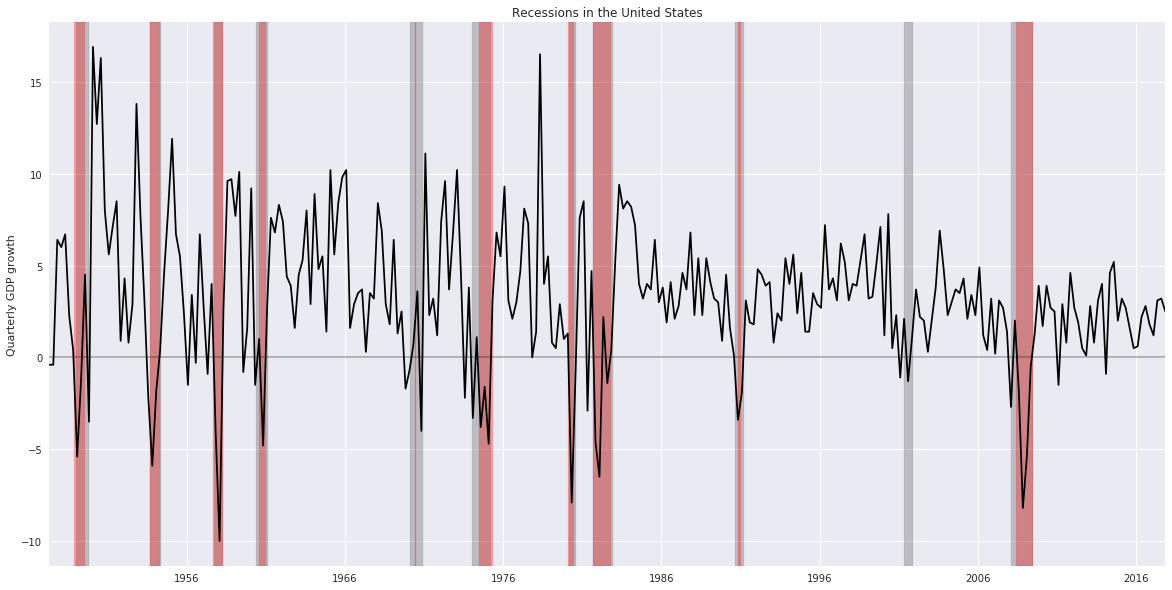

In [39]:
prediction_visualization(grid_svc.predict(X_updated), data, X_pred_vis)

## Model Selection

In [40]:
grid_bagging.best_estimator_

BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=540, random_state=None),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=171, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [41]:
performance_metrics = pd.DataFrame(columns=['f1'])
models = [grid_ada, grid_bagging, grid_knn, grid_svc]
for model in models:
    print(str(model.estimator).split('(')[0] + ': ' + str(model.best_score_))

AdaBoostClassifier: 0.943082381985
BaggingClassifier: 0.934212439301
KNeighborsClassifier: 0.84135227687
SVC: 0.736294270896


## Adding an Assumption

To further improve the performance of the model, we use an assumption on what constitutes a recession from the point of view of the NBER. Namely, a recession must last for at least 3 months.

One might argue that this assumption is problematic because it could lead to the system revising its past predictions once new data has been published. However, recall that our aim here is to mimic the NBER, which typically classifies a period as a recession multiple months after it has occured. As such, this type of revision will not occur if this system operates on the same time frame as the NBER.

There are multiple ways of implementing this assumption. We can apply it filling the 0s by 1s if there is less than 3 months separating two recession predictions, and then checking than the minimum period for a recession is greater or equal to 3 months.

In [61]:
augmented_ada_pred = grid_ada.predict(X_updated)

In [62]:
last_r = 0
for i, value in enumerate(augmented_ada_pred):
    if value:
        if last_r == 0:
            last_r = i
        if (i-last_r) < 3:
            for j in range(i-last_r):
                augmented_ada_pred[i-j] = 1.
        last_r = i

In [63]:
from itertools import groupby

def len_iter(items):
    return sum(1 for _ in items)

def consecutive_one(data):
    return min(len_iter(run) for val, run in groupby(data) if val)

# Minmum length of a sequence of 1s
consecutive_one(augmented_ada_pred)

5

In [64]:
# Total number of mistakes
len(y_updated) - sum(y_updated == augmented_ada_pred)

8

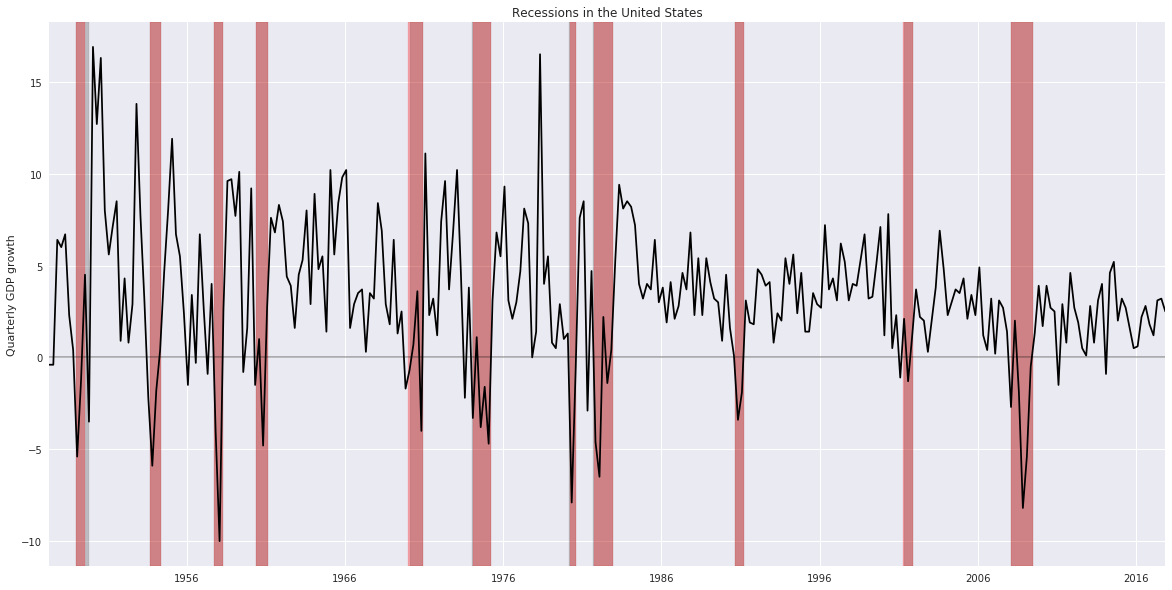

In [65]:
prediction_visualization(augmented_ada_pred, data, X_pred_vis)

# References

Mullainathan, S., & Spiess, J. (2017). [Machine Learning: An Applied Econometric Approach](https://scholar.harvard.edu/sendhil/publications/machine-learning-applied-econometric-approach). Journal of Economic Perspectives , 31 (2), 87-106.  
L.J.P. van der Maaten and G.E. Hinton. [Visualizing High-Dimensional Data Using t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf). Journal of Machine Learning Research 9(Nov):2579-2605, 2008.
Susan Athey, 2018. [The Impact of Machine Learning on Economics](http://www.nber.org/chapters/c14009.pdf), NBER Chapters, in: The Economics of Artificial Intelligence: An Agenda, National Bureau of Economic Research, Inc.